Задача нам уже знакома - нужно предсказать, сможет ли пользователь успешно закончить онлайн курс Анализ данных в R.

Мы будем считать, что пользователь успешно закончил курс, если он правильно решил больше 40 практических заданий (больше 40 баллов).

В данных:
- submission_data_test.csv
- events_data_test.csv

хранится информация о решениях и действиях для 6184 студентов за первые два дня прохождения курса. Это 6184 студентов, которые проходили курс в период с мая 2018 по январь 2019.

Используя данные о первых двух днях активности на курсе вам нужно предсказать, наберет ли пользователь более 40 баллов на курсе или нет.

В этих данных, вам доступны только первые дня активности студентов для того, чтобы сделать предсказание. На самом деле, используя эти данные, вы уже можете сделать прогноз. Например, если пользователь за первые два дня набрал 40 баллов, скорее всего он наберет более 40 баллов в дальнейшем. Чтобы подкрепить такие гипотезы, вы можете использовать данные, на которые мы исследовали в первых двух модулях курса, где для всех пользователей представлены все данные об их активности на курсе. 

In [1]:
import os
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(rc={'figure.figsize': (9, 6)})

In [2]:
%%time
PATH_TO_DATA = '../data/Stepic_Machine_Learning/'

event_data_train = pd.read_csv(os.path.join(PATH_TO_DATA, 'event_data_train.csv'))

Wall time: 2.96 s


In [3]:
event_data_train.head()

,step_id,timestamp,action,user_id
0,32815,1434340848,viewed,17632
1,32815,1434340848,passed,17632
2,32815,1434340848,discovered,17632
3,32811,1434340895,discovered,17632
4,32811,1434340895,viewed,17632


In [4]:
event_data_train['user_id'].nunique()

19234

In [5]:
submissions_data_train = pd.read_csv(os.path.join(PATH_TO_DATA, 'submissions_data_train.csv'))

In [6]:
submissions_data_train.head()

,step_id,timestamp,submission_status,user_id
0,31971,1434349275,correct,15853
1,31972,1434348300,correct,15853
2,31972,1478852149,wrong,15853
3,31972,1478852164,correct,15853
4,31976,1434348123,wrong,15853


In [7]:
submissions_data_train['user_id'].nunique()

9940

9940 унікальних користувачів засабмітили практичні завдання

## Розмітим користувачів, які успішно пройшли курс (набрали більше 40 балів)

### Виділяємо унікальні user_id в окремий датафрейм

Унікальні user_id беремо з датафрейма event_data_train

In [8]:
y_train = event_data_train[['user_id']] \
    .drop_duplicates(subset=['user_id']) \
    .reset_index().drop('index', axis=1)

In [9]:
y_train.head()

,user_id
0,17632
1,12494
2,442
3,22254
4,6646


In [10]:
y_train['user_id'].nunique()

19234

### Порахуємо кількість балів, які заробив користувач за практичні завдання 'correct'

In [11]:
users_scores = pd.crosstab(submissions_data_train['user_id'], submissions_data_train['submission_status']).reset_index()
users_scores.head()

submission_status,user_id,correct,wrong
0,2,2,0
1,3,29,23
2,5,2,2
3,8,9,21
4,14,0,1


In [12]:
users_scores[users_scores['correct'] >= 1].count()

submission_status
user_id    9794
correct    9794
wrong      9794
dtype: int64

9794 унікальних користувачів засабмітили коректне практичне завдання, тобто виконали хоча б одне практичне завдання

In [13]:
users_scores[users_scores['correct'] > 40].count()

submission_status
user_id    1968
correct    1968
wrong      1968
dtype: int64

1968 унікальних користувачів успішно завершили курс (набрали більше 40 балів на практичних завданнях)

### Добавимо інформацію про практичні завдання до унікальних user_id

In [14]:
y_train = y_train.merge(users_scores, how='outer', on='user_id')
y_train.head()

,user_id,correct,wrong
0,17632,31.0,278.0
1,12494,18.0,44.0
2,442,25.0,134.0
3,22254,24.0,54.0
4,6646,70.0,54.0


In [15]:
y_train.isnull().sum()

user_id       0
correct    9294
wrong      9294
dtype: int64

### Заповнимо пропуски нулями

Не всі користувачі робили практичні завдання

In [16]:
y_train = y_train.fillna(0)

In [17]:
y_train.isnull().sum().sum()

0

### Визначатимо користувачів, які успішно пройшли курс (набрали на ПРАКТИЧНИХ завданнях більше 40 балів)
Добавимо колонку "correct_course"

In [18]:
y_train['correct_course'] = np.where(y_train['correct'] > 40, 1, 0)
y_train['correct_course'].value_counts()

0    17266
1     1968
Name: correct_course, dtype: int64

In [19]:
y_train.head()

,user_id,correct,wrong,correct_course
0,17632,31.0,278.0,0
1,12494,18.0,44.0,0
2,442,25.0,134.0,0
3,22254,24.0,54.0,0
4,6646,70.0,54.0,1


### Розмітим користувачів, які успішно пройшли курс
Залишимо тільки колонку "correct_course"

In [20]:
y_train = y_train.drop(['correct', 'wrong'], axis=1)
y_train.head()

,user_id,correct_course
0,17632,0
1,12494,0
2,442,0
3,22254,0
4,6646,1


In [21]:
y_train['correct_course'].value_counts()

0    17266
1     1968
Name: correct_course, dtype: int64

### Зазначимо колонку user_id як індекси

In [22]:
y_train = y_train.set_index('user_id')
y_train.head()

,correct_course
user_id,
17632,0
12494,0
442,0
22254,0
6646,1


## Виділимо інформацію про користувачів за перші 2 дні на курсі

### Виділимо колонку з першим заходом (first_timestamp)

In [23]:
first_timestamp_event_data = event_data_train.groupby('user_id', as_index=False) \
    .agg({'timestamp': 'min'}) \
    .rename(columns={'timestamp': 'first_timestamp'})

In [24]:
first_timestamp_event_data.head()

,user_id,first_timestamp
0,1,1472827464
1,2,1514383364
2,3,1434358476
3,5,1466156809
4,7,1521634660


### Добавимо колонку з першим заходом плюс 1 і 2 дні

In [25]:
treshold = 2 * 24 * 60 * 60 # 2 дні
treshold

172800

In [26]:
first_timestamp_event_data['1_day_timestamp'] = first_timestamp_event_data['first_timestamp'] + (treshold / 2)
first_timestamp_event_data['2_day_timestamp'] = first_timestamp_event_data['first_timestamp'] + treshold

In [27]:
first_timestamp_event_data.head()

,user_id,first_timestamp,1_day_timestamp,2_day_timestamp
0,1,1472827464,1.472914e+09,1473000264
1,2,1514383364,1.514470e+09,1514556164
2,3,1434358476,1.434445e+09,1434531276
3,5,1466156809,1.466243e+09,1466329609
4,7,1521634660,1.521721e+09,1521807460


### Зробимо обєднання з event_data_train

In [28]:
event_data_train = event_data_train.merge(first_timestamp_event_data, on='user_id', how='outer')

In [29]:
event_data_train.head()

,step_id,timestamp,action,user_id,first_timestamp,1_day_timestamp,2_day_timestamp
0,32815,1434340848,viewed,17632,1434340848,1.434427e+09,1434513648
1,32815,1434340848,passed,17632,1434340848,1.434427e+09,1434513648
2,32815,1434340848,discovered,17632,1434340848,1.434427e+09,1434513648
3,32811,1434340895,discovered,17632,1434340848,1.434427e+09,1434513648
4,32811,1434340895,viewed,17632,1434340848,1.434427e+09,1434513648


In [30]:
event_data_train.shape

(3480703, 7)

In [31]:
event_data_train['user_id'].nunique()

19234

### Врешті виділимо дані тільки по першим двом дням

In [32]:
event_data_train_first_2_days = event_data_train[event_data_train['timestamp'] < event_data_train['2_day_timestamp']]

In [33]:
event_data_train_first_2_days.shape

(906194, 7)

Перевіряємо чи кількість унікальних користувачів залишилась така ж

In [34]:
event_data_train_first_2_days['user_id'].nunique()

19234

In [35]:
event_data_train_first_2_days.head()

,step_id,timestamp,action,user_id,first_timestamp,1_day_timestamp,2_day_timestamp
0,32815,1434340848,viewed,17632,1434340848,1.434427e+09,1434513648
1,32815,1434340848,passed,17632,1434340848,1.434427e+09,1434513648
2,32815,1434340848,discovered,17632,1434340848,1.434427e+09,1434513648
3,32811,1434340895,discovered,17632,1434340848,1.434427e+09,1434513648
4,32811,1434340895,viewed,17632,1434340848,1.434427e+09,1434513648


Виділимо інформація про перші 2 два дні для **submissions_data_train** - потрібно використовувати проміжок у 2 дні від старту по таблиці з івентами так, як сабміти ідуть пізніше і 2 дні з початку сабмітів не дорівнюють двом дням на курсі (сабмітити могли на певний день після старту), тому дабавимо колонки по 1 і 2 дням з таблиці з івентами

In [36]:
first_timestamp_submissions_data = submissions_data_train.groupby('user_id', as_index=False) \
    .agg({'timestamp': 'min'}) \
    .rename(columns={'timestamp': 'first_timestamp'})
    
first_timestamp_submissions_data['1_day_timestamp'] = first_timestamp_submissions_data['first_timestamp'] + (treshold / 2)
first_timestamp_submissions_data['2_day_timestamp'] = first_timestamp_submissions_data['first_timestamp'] + treshold

submissions_data_train = submissions_data_train.merge(first_timestamp_submissions_data, on='user_id', how='outer')

In [37]:
submissions_data_train.head()

,step_id,timestamp,submission_status,user_id,first_timestamp,1_day_timestamp,2_day_timestamp
0,31971,1434349275,correct,15853,1434346056,1.434432e+09,1434518856
1,31972,1434348300,correct,15853,1434346056,1.434432e+09,1434518856
2,31972,1478852149,wrong,15853,1434346056,1.434432e+09,1434518856
3,31972,1478852164,correct,15853,1434346056,1.434432e+09,1434518856
4,31976,1434348123,wrong,15853,1434346056,1.434432e+09,1434518856


In [38]:
# submissions_data_train = submissions_data_train.merge(event_data_train_first_2_days[['user_id', '1_day_timestamp', '2_day_timestamp']], 
#                                                       on='user_id', how='outer')
# submissions_data_train.head()

In [39]:
submissions_data_train_first_2_days = submissions_data_train[submissions_data_train['timestamp'] < submissions_data_train['2_day_timestamp']]

In [40]:
submissions_data_train.shape

(509104, 7)

In [41]:
submissions_data_train['user_id'].nunique()

9940

In [42]:
submissions_data_train_first_2_days.head()

,step_id,timestamp,submission_status,user_id,first_timestamp,1_day_timestamp,2_day_timestamp
0,31971,1434349275,correct,15853,1434346056,1.434432e+09,1434518856
1,31972,1434348300,correct,15853,1434346056,1.434432e+09,1434518856
4,31976,1434348123,wrong,15853,1434346056,1.434432e+09,1434518856
5,31976,1434348188,correct,15853,1434346056,1.434432e+09,1434518856
7,31977,1434347371,correct,15853,1434346056,1.434432e+09,1434518856


In [43]:
submissions_data_train_first_2_days.shape

(134612, 7)

Перевіряємо чи кількість унікальних користувачів залишилась така ж

In [44]:
submissions_data_train_first_2_days['user_id'].nunique()

9940

## Проаналізуємо і перетворимо дані у формат, який придатний для навчання моделі

- кількість днів, які робив івенти +
- кількість днів, які сабмітив +
- чи взагалі зробив сабміт +
- чи зробив коректний сабміт +
- чи перший сабміт коректний -
- чи пройшов івент +
- набрав 40 балів за івенти ?
- різниця між коректними і помилковими сабмітами -
- ratio між коректними і помилковими сабмітами +
- різниця між коректними і сумою усіх сабмітів -
- ratio між коректними і сумою усіх сабмітів +
- різниця між пройденими та іншими івентами -
- ratio між пройденими та іншими івентами +
- різниця між пройденими івентами та сумою усіх івентів -
- ratio між пройденими івентами та сумою усіх івентів +
- стартовий день тижня +
- чи стартовий день вихідний +
- стартовий місяць +
- стартовий рік +
- стартовий день місяця +
- pivot_table по івентам +
- pivot_table по сабмітам +
- кількість унікальних івентів +
- кількість унікальних сабмітів +
- часовий проміжок між першим івентом і першим сабмітом -
- середній часовий проміжок між сабмітами -
- середній часовий проміжок між івентами -
- сума усіх забмітів +
- сума усіх івентів +


- ratio між коректними сабмітами в перший і другий день
- ratio між пройденими івентами в перший і другий день
- сума усіх сабмітів в перший день
- сума усіх сабмітів в другий день
- сума усіх івентів в перший день
- сума усіх івентів в другий день

### Підготуємо заготовку в усіма user_id

In [45]:
X_train = event_data_train[['user_id']] \
    .drop_duplicates(subset=['user_id']) \
    .reset_index().drop('index', axis=1)

In [46]:
X_train.head()

,user_id
0,17632
1,12494
2,442
3,22254
4,6646


### Додамо дату і коротку дату для "event_data_train_first_2_days"

In [47]:
event_data_train_first_2_days['date'] = pd.to_datetime(event_data_train_first_2_days['timestamp'], unit='s')
event_data_train_first_2_days['date_short'] = event_data_train_first_2_days['date'].dt.date

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [48]:
event_data_train_first_2_days.head()

,step_id,timestamp,action,user_id,first_timestamp,1_day_timestamp,2_day_timestamp,date,date_short
0,32815,1434340848,viewed,17632,1434340848,1.434427e+09,1434513648,2015-06-15 04:00:48,2015-06-15
1,32815,1434340848,passed,17632,1434340848,1.434427e+09,1434513648,2015-06-15 04:00:48,2015-06-15
2,32815,1434340848,discovered,17632,1434340848,1.434427e+09,1434513648,2015-06-15 04:00:48,2015-06-15
3,32811,1434340895,discovered,17632,1434340848,1.434427e+09,1434513648,2015-06-15 04:01:35,2015-06-15
4,32811,1434340895,viewed,17632,1434340848,1.434427e+09,1434513648,2015-06-15 04:01:35,2015-06-15


Аналогічно для **submissions_data_train_first_2_days**

In [49]:
submissions_data_train_first_2_days['date'] = pd.to_datetime(submissions_data_train_first_2_days['timestamp'], unit='s')
submissions_data_train_first_2_days['date_short'] = submissions_data_train_first_2_days['date'].dt.date

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [50]:
submissions_data_train_first_2_days.head()

,step_id,timestamp,submission_status,user_id,first_timestamp,1_day_timestamp,2_day_timestamp,date,date_short
0,31971,1434349275,correct,15853,1434346056,1.434432e+09,1434518856,2015-06-15 06:21:15,2015-06-15
1,31972,1434348300,correct,15853,1434346056,1.434432e+09,1434518856,2015-06-15 06:05:00,2015-06-15
4,31976,1434348123,wrong,15853,1434346056,1.434432e+09,1434518856,2015-06-15 06:02:03,2015-06-15
5,31976,1434348188,correct,15853,1434346056,1.434432e+09,1434518856,2015-06-15 06:03:08,2015-06-15
7,31977,1434347371,correct,15853,1434346056,1.434432e+09,1434518856,2015-06-15 05:49:31,2015-06-15


### Порахуємо кількість унікальних днів, які користувач провів на курсі

In [51]:
event_unique_day = event_data_train_first_2_days.groupby('user_id')['date_short'].nunique().to_frame().reset_index()
event_unique_day.head()

,user_id,date_short
0,1,1
1,2,1
2,3,1
3,5,1
4,7,1


In [52]:
event_unique_day['date_short'].value_counts()

1    14225
2     3420
3     1589
Name: date_short, dtype: int64

In [53]:
X_train = X_train.merge(event_unique_day, on='user_id', how='outer')

In [54]:
X_train.head()

,user_id,date_short
0,17632,2
1,12494,2
2,442,1
3,22254,2
4,6646,1


Аналогічно для **submissions_data_train_first_2_days**

In [55]:
submissions_unique_day = submissions_data_train_first_2_days.groupby('user_id')['date_short'].nunique().to_frame().reset_index()
submissions_unique_day.head()

,user_id,date_short
0,2,1
1,3,1
2,5,1
3,8,1
4,14,1


In [56]:
submissions_unique_day['date_short'].value_counts()

1    6897
2    2284
3     759
Name: date_short, dtype: int64

In [57]:
X_train = X_train.merge(submissions_unique_day, on='user_id', how='outer')

In [58]:
X_train.head()

,user_id,date_short_x,date_short_y
0,17632,2,1.0
1,12494,2,1.0
2,442,1,1.0
3,22254,2,1.0
4,6646,1,1.0


In [59]:
X_train = X_train.rename(columns={'date_short_x': 'event_unique_days', 'date_short_y': 'subm_unique_days'})

In [60]:
X_train.head()

,user_id,event_unique_days,subm_unique_days
0,17632,2,1.0
1,12494,2,1.0
2,442,1,1.0
3,22254,2,1.0
4,6646,1,1.0


In [61]:
X_train.isnull().sum()

user_id                 0
event_unique_days       0
subm_unique_days     9294
dtype: int64

### Порахуємо скільки унікальних степів зробив користувач

In [62]:
event_step_tried = event_data_train_first_2_days.groupby('user_id')['step_id'].nunique().to_frame().reset_index() \
    .rename(columns={'step_id': 'event_steps_tried'})

In [63]:
event_step_tried.head()

,user_id,event_steps_tried
0,1,1
1,2,9
2,3,15
3,5,1
4,7,1


In [64]:
X_train = X_train.merge(event_step_tried, on='user_id', how='outer')

In [65]:
X_train.head()

,user_id,event_unique_days,subm_unique_days,event_steps_tried
0,17632,2,1.0,17
1,12494,2,1.0,17
2,442,1,1.0,19
3,22254,2,1.0,27
4,6646,1,1.0,2


Аналогічно для **submissions_data_train_first_2_days**

In [66]:
subm_step_tried = submissions_data_train_first_2_days.groupby('user_id')['step_id'].nunique().to_frame().reset_index() \
    .rename(columns={'step_id': 'subm_step_tried'})

In [67]:
subm_step_tried.head()

,user_id,subm_step_tried
0,2,2
1,3,4
2,5,2
3,8,11
4,14,1


In [68]:
X_train = X_train.merge(subm_step_tried, on='user_id', how='outer')

In [69]:
X_train.head()

,user_id,event_unique_days,subm_unique_days,event_steps_tried,subm_step_tried
0,17632,2,1.0,17,2.0
1,12494,2,1.0,17,4.0
2,442,1,1.0,19,6.0
3,22254,2,1.0,27,8.0
4,6646,1,1.0,2,2.0


In [70]:
X_train.isnull().sum()

user_id                 0
event_unique_days       0
subm_unique_days     9294
event_steps_tried       0
subm_step_tried      9294
dtype: int64

### Порахуємо івенти по їх типам

In [71]:
event_action = pd.crosstab(event_data_train_first_2_days['user_id'], event_data_train_first_2_days['action']).reset_index()

In [72]:
event_action.head()

action,user_id,discovered,passed,started_attempt,viewed
0,1,1,0,0,1
1,2,9,9,2,9
2,3,15,15,4,20
3,5,1,1,0,1
4,7,1,1,0,1


Порахумо ratio між **passed** і (**discovered, viewed, started_attempt**)

In [73]:
event_action['passed_ratio'] = event_action['passed'] / (event_action['passed'] + event_action['discovered'] \
                                                         + event_action['started_attempt'] \
                                                         + event_action['viewed'])

In [74]:
event_action.head()

action,user_id,discovered,passed,started_attempt,viewed,passed_ratio
0,1,1,0,0,1,0.000000
1,2,9,9,2,9,0.310345
2,3,15,15,4,20,0.277778
3,5,1,1,0,1,0.333333
4,7,1,1,0,1,0.333333


In [75]:
event_action.isnull().sum()

action
user_id            0
discovered         0
passed             0
started_attempt    0
viewed             0
passed_ratio       0
dtype: int64

In [76]:
X_train = X_train.merge(event_action, on='user_id', how='outer')

In [77]:
X_train.head()

,user_id,event_unique_days,subm_unique_days,event_steps_tried,subm_step_tried,discovered,passed,started_attempt,viewed,passed_ratio
0,17632,2,1.0,17,2.0,17,14,2,29,0.225806
1,12494,2,1.0,17,4.0,17,14,1,24,0.250000
2,442,1,1.0,19,6.0,19,18,7,31,0.240000
3,22254,2,1.0,27,8.0,27,27,10,36,0.270000
4,6646,1,1.0,2,2.0,2,2,0,3,0.285714


### Порахуємо сабміти по їх типам

In [78]:
submission_status = pd.crosstab(submissions_data_train_first_2_days['user_id'], 
                                submissions_data_train_first_2_days['submission_status']).reset_index()

In [79]:
submission_status.head()

submission_status,user_id,correct,wrong
0,2,2,0
1,3,4,4
2,5,2,2
3,8,9,21
4,14,0,1


Порахумо ratio для **submission_status**

In [80]:
submission_status['correct_ratio'] = submission_status['correct'] / (submission_status['correct'] + submission_status['wrong'])

In [81]:
submission_status.head()

submission_status,user_id,correct,wrong,correct_ratio
0,2,2,0,1.0
1,3,4,4,0.5
2,5,2,2,0.5
3,8,9,21,0.3
4,14,0,1,0.0


In [82]:
submission_status.isnull().sum()

submission_status
user_id          0
correct          0
wrong            0
correct_ratio    0
dtype: int64

In [83]:
X_train = X_train.merge(submission_status, on='user_id', how='outer')

In [84]:
X_train.head()

,user_id,event_unique_days,subm_unique_days,event_steps_tried,subm_step_tried,discovered,passed,started_attempt,viewed,passed_ratio,correct,wrong,correct_ratio
0,17632,2,1.0,17,2.0,17,14,2,29,0.225806,2.0,0.0,1.000000
1,12494,2,1.0,17,4.0,17,14,1,24,0.250000,4.0,2.0,0.666667
2,442,1,1.0,19,6.0,19,18,7,31,0.240000,5.0,16.0,0.238095
3,22254,2,1.0,27,8.0,27,27,10,36,0.270000,8.0,15.0,0.347826
4,6646,1,1.0,2,2.0,2,2,0,3,0.285714,2.0,0.0,1.000000


In [85]:
X_train.isnull().sum()

user_id                 0
event_unique_days       0
subm_unique_days     9294
event_steps_tried       0
subm_step_tried      9294
discovered              0
passed                  0
started_attempt         0
viewed                  0
passed_ratio            0
correct              9294
wrong                9294
correct_ratio        9294
dtype: int64

In [86]:
X_train['passed'].value_counts().head()

1     5122
0     2007
2     1280
10     968
9      897
Name: passed, dtype: int64

Добавимо колонку - чи пройшов хоч одне завдання **passed**

In [87]:
X_train['action_passed'] = np.where(X_train['passed'] > 0, 1, 0)

In [88]:
X_train.head()

,user_id,event_unique_days,subm_unique_days,event_steps_tried,subm_step_tried,discovered,passed,started_attempt,viewed,passed_ratio,correct,wrong,correct_ratio,action_passed
0,17632,2,1.0,17,2.0,17,14,2,29,0.225806,2.0,0.0,1.000000,1
1,12494,2,1.0,17,4.0,17,14,1,24,0.250000,4.0,2.0,0.666667,1
2,442,1,1.0,19,6.0,19,18,7,31,0.240000,5.0,16.0,0.238095,1
3,22254,2,1.0,27,8.0,27,27,10,36,0.270000,8.0,15.0,0.347826,1
4,6646,1,1.0,2,2.0,2,2,0,3,0.285714,2.0,0.0,1.000000,1


Добавимо колонку - чи зробив хоч один сабміт **correct** або **wrong** (в даному випадку отримають всі, бо користувачі, які не мають ні коректних ні помилкових сабмітів поки що немає в таблиці - NaN)

In [89]:
X_train['is_submit'] = np.where(((X_train['correct'] > 0) | (X_train['wrong'] > 0)), 1, 0)

In [90]:
X_train.head()

,user_id,event_unique_days,subm_unique_days,event_steps_tried,subm_step_tried,discovered,passed,started_attempt,viewed,passed_ratio,correct,wrong,correct_ratio,action_passed,is_submit
0,17632,2,1.0,17,2.0,17,14,2,29,0.225806,2.0,0.0,1.000000,1,1
1,12494,2,1.0,17,4.0,17,14,1,24,0.250000,4.0,2.0,0.666667,1,1
2,442,1,1.0,19,6.0,19,18,7,31,0.240000,5.0,16.0,0.238095,1,1
3,22254,2,1.0,27,8.0,27,27,10,36,0.270000,8.0,15.0,0.347826,1,1
4,6646,1,1.0,2,2.0,2,2,0,3,0.285714,2.0,0.0,1.000000,1,1


Добавимо колонку - чи зробив хоч один **correct** сабміт

In [91]:
X_train['is_correct_submit'] = np.where(X_train['correct'] > 0, 1, 0)

In [92]:
X_train.head()

,user_id,event_unique_days,subm_unique_days,event_steps_tried,subm_step_tried,discovered,passed,started_attempt,viewed,passed_ratio,correct,wrong,correct_ratio,action_passed,is_submit,is_correct_submit
0,17632,2,1.0,17,2.0,17,14,2,29,0.225806,2.0,0.0,1.000000,1,1,1
1,12494,2,1.0,17,4.0,17,14,1,24,0.250000,4.0,2.0,0.666667,1,1,1
2,442,1,1.0,19,6.0,19,18,7,31,0.240000,5.0,16.0,0.238095,1,1,1
3,22254,2,1.0,27,8.0,27,27,10,36,0.270000,8.0,15.0,0.347826,1,1,1
4,6646,1,1.0,2,2.0,2,2,0,3,0.285714,2.0,0.0,1.000000,1,1,1


In [93]:
X_train['is_correct_submit'].value_counts()

1    9781
0    9453
Name: is_correct_submit, dtype: int64

### Добавимо ознаки по даті

Виділимо тільки стартовий день для кожного користувача

In [94]:
event_data_train_first_2_days.head()

,step_id,timestamp,action,user_id,first_timestamp,1_day_timestamp,2_day_timestamp,date,date_short
0,32815,1434340848,viewed,17632,1434340848,1.434427e+09,1434513648,2015-06-15 04:00:48,2015-06-15
1,32815,1434340848,passed,17632,1434340848,1.434427e+09,1434513648,2015-06-15 04:00:48,2015-06-15
2,32815,1434340848,discovered,17632,1434340848,1.434427e+09,1434513648,2015-06-15 04:00:48,2015-06-15
3,32811,1434340895,discovered,17632,1434340848,1.434427e+09,1434513648,2015-06-15 04:01:35,2015-06-15
4,32811,1434340895,viewed,17632,1434340848,1.434427e+09,1434513648,2015-06-15 04:01:35,2015-06-15


In [95]:
event_data_train_first_2_days.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 906194 entries, 0 to 3480702
Data columns (total 9 columns):
step_id            906194 non-null int64
timestamp          906194 non-null int64
action             906194 non-null object
user_id            906194 non-null int64
first_timestamp    906194 non-null int64
1_day_timestamp    906194 non-null float64
2_day_timestamp    906194 non-null int64
date               906194 non-null datetime64[ns]
date_short         906194 non-null object
dtypes: datetime64[ns](1), float64(1), int64(5), object(2)
memory usage: 69.1+ MB


In [96]:
# event_data_train_first_timestamp = event_data_train_first_2_days[event_data_train_first_2_days['timestamp'] \
#                                                                  == event_data_train_first_2_days['first_timestamp']]

In [97]:
# event_data_train_first_timestamp.head()

In [98]:
# event_data_train_first_timestamp = event_data_train_first_timestamp.drop_duplicates(subset=['user_id'])

In [99]:
# event_data_train_first_timestamp.head()

In [100]:
# event_data_train_first_timestamp.shape

Добавимо колонку - стартовий день тижня (рахуємо по таблиці івентів)

In [101]:
# event_data_train_first_timestamp['day_of_week'] = event_data_train_first_timestamp['date'].dt.weekday

In [102]:
# event_data_train_first_timestamp['day_of_week'].value_counts()

Добавимо колонку - чи вихідний

In [103]:
# event_data_train_first_timestamp['is_weekend'] = np.where(event_data_train_first_timestamp['day_of_week'] > 4, 1, 0)

In [104]:
# event_data_train_first_timestamp['is_weekend'].value_counts()

In [105]:
# event_data_train_first_timestamp.head()

Добавимо колонку - стартовий рік

In [106]:
# event_data_train_first_timestamp['year'] = event_data_train_first_timestamp['date'].dt.year

In [107]:
# event_data_train_first_timestamp['year'].value_counts()

In [108]:
# event_data_train_first_timestamp.head()

Добавимо колонку - стартовий місяць

In [109]:
# event_data_train_first_timestamp['month'] = event_data_train_first_timestamp['date'].dt.month

In [110]:
# event_data_train_first_timestamp['month'].value_counts()

In [111]:
# event_data_train_first_timestamp.head()

Добавимо колонку - стартовий день місяця

In [112]:
# event_data_train_first_timestamp['day_of_month'] = event_data_train_first_timestamp['date'].dt.day

In [113]:
# event_data_train_first_timestamp['day_of_month'].value_counts().head()

In [114]:
# event_data_train_first_timestamp.head()

Обєднаємо колонки **day_of_week, is_weekend, year, month, day_of_month** з основною базою X_train

In [115]:
# X_train = X_train.merge(event_data_train_first_timestamp[['user_id', 'day_of_week', 'is_weekend', 
#                                                           'year', 'month', 'day_of_month']], on='user_id', how='outer')

In [116]:
X_train.head()

,user_id,event_unique_days,subm_unique_days,event_steps_tried,subm_step_tried,discovered,passed,started_attempt,viewed,passed_ratio,correct,wrong,correct_ratio,action_passed,is_submit,is_correct_submit
0,17632,2,1.0,17,2.0,17,14,2,29,0.225806,2.0,0.0,1.000000,1,1,1
1,12494,2,1.0,17,4.0,17,14,1,24,0.250000,4.0,2.0,0.666667,1,1,1
2,442,1,1.0,19,6.0,19,18,7,31,0.240000,5.0,16.0,0.238095,1,1,1
3,22254,2,1.0,27,8.0,27,27,10,36,0.270000,8.0,15.0,0.347826,1,1,1
4,6646,1,1.0,2,2.0,2,2,0,3,0.285714,2.0,0.0,1.000000,1,1,1


In [117]:
X_train.isnull().sum()

user_id                 0
event_unique_days       0
subm_unique_days     9294
event_steps_tried       0
subm_step_tried      9294
discovered              0
passed                  0
started_attempt         0
viewed                  0
passed_ratio            0
correct              9294
wrong                9294
correct_ratio        9294
action_passed           0
is_submit               0
is_correct_submit       0
dtype: int64

In [118]:
################################################################################################################################

In [119]:
X_train['correct_wrong_ratio'] = X_train['correct'] / (X_train['wrong'] + 0.001)

In [120]:
X_train['passed_discovered_ratio'] = X_train['passed'] / (X_train['discovered'] + 0.001)
X_train['passed_started_attempt_ratio'] = X_train['passed'] / (X_train['started_attempt'] + 0.001)
X_train['passed_viewed_ratio'] = X_train['passed'] / (X_train['viewed'] + 0.001)

In [121]:
X_train['correct_passed_ratio'] = X_train['correct'] / (X_train['passed'] + 0.001)

In [122]:
# X_train = X_train.replace([np.inf, -np.inf], np.nan)

In [123]:
# X_train.head()

In [124]:
################################################################################################################################

In [125]:
X_train['total_subm'] = X_train['correct'] + X_train['wrong']
X_train['total_events'] = X_train['discovered'] + X_train['started_attempt'] + X_train['viewed'] + X_train['passed']

In [126]:
################################################################################################################################

In [127]:
X_train.shape

(19234, 23)

In [128]:
X_train.columns

Index(['user_id', 'event_unique_days', 'subm_unique_days', 'event_steps_tried',
       'subm_step_tried', 'discovered', 'passed', 'started_attempt', 'viewed',
       'passed_ratio', 'correct', 'wrong', 'correct_ratio', 'action_passed',
       'is_submit', 'is_correct_submit', 'correct_wrong_ratio',
       'passed_discovered_ratio', 'passed_started_attempt_ratio',
       'passed_viewed_ratio', 'correct_passed_ratio', 'total_subm',
       'total_events'],
      dtype='object')

In [129]:
X_train.head()

,user_id,event_unique_days,subm_unique_days,event_steps_tried,subm_step_tried,discovered,passed,started_attempt,viewed,passed_ratio,...,action_passed,is_submit,is_correct_submit,correct_wrong_ratio,passed_discovered_ratio,passed_started_attempt_ratio,passed_viewed_ratio,correct_passed_ratio,total_subm,total_events
0,17632,2,1.0,17,2.0,17,14,2,29,0.225806,...,1,1,1,2000.000000,0.823481,6.996502,0.482742,0.142847,2.0,62
1,12494,2,1.0,17,4.0,17,14,1,24,0.250000,...,1,1,1,1.999000,0.823481,13.986014,0.583309,0.285694,6.0,56
2,442,1,1.0,19,6.0,19,18,7,31,0.240000,...,1,1,1,0.312480,0.947319,2.571061,0.580626,0.277762,21.0,75
3,22254,2,1.0,27,8.0,27,27,10,36,0.270000,...,1,1,1,0.533298,0.999963,2.699730,0.749979,0.296285,23.0,100
4,6646,1,1.0,2,2.0,2,2,0,3,0.285714,...,1,1,1,2000.000000,0.999500,2000.000000,0.666445,0.999500,2.0,7


### Заповнимо пропуски нулями

In [130]:
X_train = X_train.fillna(0)

In [131]:
X_train.isnull().sum().sum()

0

In [132]:
################################################################################################################################

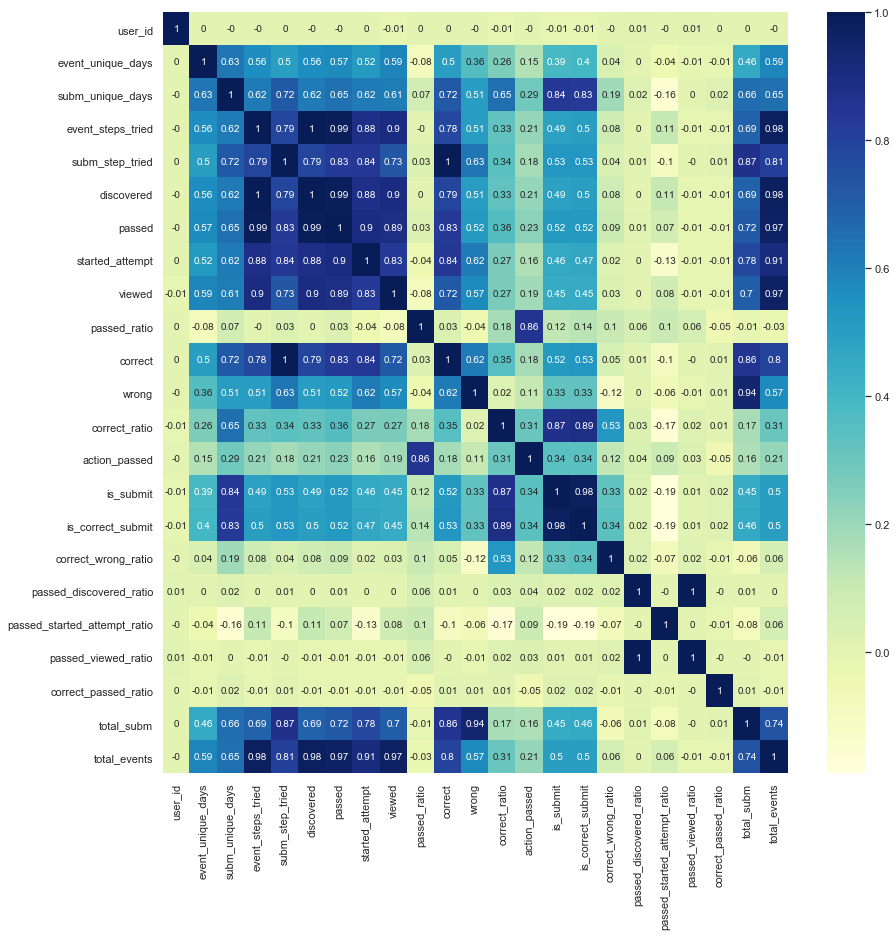

In [133]:
plt.figure(figsize=(14, 14))
sns.heatmap(X_train.corr().round(2), cmap="YlGnBu", annot=True);

In [134]:
################################################################################################################################

In [135]:
# X_train.columns

In [136]:
# X_train = X_train[['user_id', 
#                    'passed_ratio', 'wrong', 
#                    'correct_ratio', 'correct', 
#                    'year',
#                    'month', 'day_of_month']].copy()

In [137]:
# plt.figure(figsize=(14, 14))
# sns.heatmap(X_train.corr().round(2), cmap="YlGnBu", annot=True);

In [138]:
################################################################################################################################

### Зазначимо 'user_id' як індекс

In [139]:
# X_train = X_train.set_index(['user_id'])

In [140]:
X_train.head()

,user_id,event_unique_days,subm_unique_days,event_steps_tried,subm_step_tried,discovered,passed,started_attempt,viewed,passed_ratio,...,action_passed,is_submit,is_correct_submit,correct_wrong_ratio,passed_discovered_ratio,passed_started_attempt_ratio,passed_viewed_ratio,correct_passed_ratio,total_subm,total_events
0,17632,2,1.0,17,2.0,17,14,2,29,0.225806,...,1,1,1,2000.000000,0.823481,6.996502,0.482742,0.142847,2.0,62
1,12494,2,1.0,17,4.0,17,14,1,24,0.250000,...,1,1,1,1.999000,0.823481,13.986014,0.583309,0.285694,6.0,56
2,442,1,1.0,19,6.0,19,18,7,31,0.240000,...,1,1,1,0.312480,0.947319,2.571061,0.580626,0.277762,21.0,75
3,22254,2,1.0,27,8.0,27,27,10,36,0.270000,...,1,1,1,0.533298,0.999963,2.699730,0.749979,0.296285,23.0,100
4,6646,1,1.0,2,2.0,2,2,0,3,0.285714,...,1,1,1,2000.000000,0.999500,2000.000000,0.666445,0.999500,2.0,7


In [141]:
X_train.describe()

,user_id,event_unique_days,subm_unique_days,event_steps_tried,subm_step_tried,discovered,passed,started_attempt,viewed,passed_ratio,...,action_passed,is_submit,is_correct_submit,correct_wrong_ratio,passed_discovered_ratio,passed_started_attempt_ratio,passed_viewed_ratio,correct_passed_ratio,total_subm,total_events
count,19234.000000,19234.000000,19234.000000,19234.000000,19234.000000,19234.000000,19234.000000,19234.000000,19234.000000,19234.000000,...,19234.000000,19234.000000,19234.000000,19234.000000,19234.000000,19234.000000,19234.000000,19234.000000,19234.000000,19234.000000
mean,13363.573672,1.343038,0.714464,12.399969,3.689560,12.364719,11.406936,4.109754,19.232765,0.246954,...,0.895654,0.516793,0.508527,484.755974,0.893316,1030.782011,0.739557,2.488830,6.998648,47.114173
std,7750.057260,0.624989,0.823593,18.065414,6.763051,18.037576,16.813943,8.034247,32.074984,0.098464,...,0.305717,0.499731,0.499940,1400.976724,7.211159,3933.789019,7.212776,108.390880,15.001312,72.263644
min,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,6636.500000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.222222,...,1.000000,0.000000,0.000000,0.000000,0.857082,2.428456,0.499750,0.000000,0.000000,3.000000
50%,13358.000000,1.000000,1.000000,6.000000,1.000000,6.000000,5.000000,1.000000,7.000000,0.272727,...,1.000000,1.000000,1.000000,0.187292,0.999001,4.497751,0.749938,0.080538,1.000000,19.000000
75%,20073.750000,2.000000,1.000000,16.000000,4.000000,16.000000,14.000000,5.000000,23.000000,0.333333,...,1.000000,1.000000,1.000000,3.320478,0.999833,1000.000000,0.999001,0.312480,7.000000,58.000000
max,26798.000000,3.000000,3.000000,198.000000,76.000000,198.000000,198.000000,135.000000,568.000000,0.500000,...,1.000000,1.000000,1.000000,65000.000000,1000.000000,112000.000000,1000.000000,9000.000000,219.000000,884.000000


### Створимо метод, який виконує всі попередні дії

In [142]:
def data_preprocessing(events_data, submission_data):
    events_data_test = events_data
    submission_data_test = submission_data
    
    X = events_data_test[['user_id']] \
        .drop_duplicates(subset=['user_id']) \
        .reset_index().drop('index', axis=1)

    first_timestamp_events_data_test = events_data_test.groupby('user_id', as_index=False) \
        .agg({'timestamp': 'min'}) \
        .rename(columns={'timestamp': 'first_timestamp'})

    events_data_test = events_data_test.merge(first_timestamp_events_data_test, on='user_id', how='outer')

    events_data_test['date'] = pd.to_datetime(events_data_test['timestamp'], unit='s')
    events_data_test['date_short'] = events_data_test['date'].dt.date

    event_unique_day = events_data_test.groupby('user_id')['date_short'].nunique().to_frame().reset_index()

    X = X.merge(event_unique_day, on='user_id', how='outer')

    submission_data_test['date'] = pd.to_datetime(submission_data_test['timestamp'], unit='s')
    submission_data_test['date_short'] = submission_data_test['date'].dt.date

    submissions_unique_day = submission_data_test.groupby('user_id')['date_short'].nunique().to_frame().reset_index()

    X = X.merge(submissions_unique_day, on='user_id', how='outer')

    X = X.rename(columns={'date_short_x': 'event_unique_days', 'date_short_y': 'subm_unique_days'})

    event_step_tried = events_data_test.groupby('user_id')['step_id'].nunique().to_frame().reset_index() \
        .rename(columns={'step_id': 'event_steps_tried'})

    X = X.merge(event_step_tried, on='user_id', how='outer')

    subm_step_tried = submission_data_test.groupby('user_id')['step_id'].nunique().to_frame().reset_index() \
        .rename(columns={'step_id': 'subm_step_tried'})

    X = X.merge(subm_step_tried, on='user_id', how='outer')

    event_action = pd.crosstab(events_data_test['user_id'], events_data_test['action']).reset_index()

    event_action['passed_ratio'] = event_action['passed'] / (event_action['passed'] + event_action['discovered'] \
                                                             + event_action['started_attempt'] \
                                                             + event_action['viewed'])

    X = X.merge(event_action, on='user_id', how='outer')

    submission_status = pd.crosstab(submission_data_test['user_id'], 
                                    submission_data_test['submission_status']).reset_index()

    submission_status['correct_ratio'] = submission_status['correct'] / (submission_status['correct'] + submission_status['wrong'])

    X = X.merge(submission_status, on='user_id', how='outer')

    X['action_passed'] = np.where(X['passed'] > 0, 1, 0)

    X['is_submit'] = np.where(((X['correct'] > 0) | (X['wrong'] > 0)), 1, 0)

    X['is_correct_submit'] = np.where(X['correct'] > 0, 1, 0)

#     events_data_test_first_timestamp = events_data_test[events_data_test['timestamp'] \
#                                                        == events_data_test['first_timestamp']]

#     events_data_test_first_timestamp = events_data_test_first_timestamp.drop_duplicates(subset=['user_id'])

#     events_data_test_first_timestamp['day_of_week'] = events_data_test_first_timestamp['date'].dt.weekday
#     events_data_test_first_timestamp['is_weekend'] = np.where(events_data_test_first_timestamp['day_of_week'] > 4, 1, 0)
#     events_data_test_first_timestamp['year'] = events_data_test_first_timestamp['date'].dt.year
#     events_data_test_first_timestamp['month'] = events_data_test_first_timestamp['date'].dt.month
#     events_data_test_first_timestamp['day_of_month'] = events_data_test_first_timestamp['date'].dt.day

#     X = X.merge(events_data_test_first_timestamp[['user_id', 'day_of_week', 'is_weekend', 
#                                                            'year', 'month', 'day_of_month']], on='user_id', how='outer')
    
    X['correct_wrong_ratio'] = X['correct'] / (X['wrong'] + 0.001)

    X['passed_discovered_ratio'] = X['passed'] / (X['discovered'] + 0.001)
    X['passed_started_attempt_ratio'] = X['passed'] / (X['started_attempt'] + 0.001)
    X['passed_viewed_ratio'] = X['passed'] / (X['viewed'] + 0.001)

    X['correct_passed_ratio'] = X['correct'] / (X['passed'] + 0.001)
    
    # #     X = X.replace([np.inf, -np.inf], np.nan)
    
    X['total_subm'] = X['correct'] + X['wrong']
    X['total_events'] = X['discovered'] + X['started_attempt'] + X['viewed'] + X['passed']

#     X = X[['user_id', 
#            'passed_ratio', 'wrong', 
#            'correct_ratio', 'correct', 
#            'year',
#            'month', 'day_of_month']].copy()

    X = X.fillna(0)

#     X = X.set_index(['user_id'])

    return X

### Поділимо з датафреймів з івентами і сабмітами окремі для першого і другого дня

In [143]:
print(event_data_train_first_2_days.shape)
print(event_data_train_first_2_days['user_id'].nunique())

(906194, 9)
19234


In [144]:
event_data_train_day_1 = event_data_train_first_2_days[event_data_train_first_2_days['timestamp'] < \
                                                       event_data_train_first_2_days['1_day_timestamp']]

In [145]:
print(event_data_train_day_1.shape)
print(event_data_train_day_1['user_id'].nunique())

(751327, 9)
19234


In [146]:
event_data_train_day_2 = event_data_train_first_2_days[event_data_train_first_2_days['timestamp'] >= \
                                                       event_data_train_first_2_days['1_day_timestamp']]

In [147]:
print(event_data_train_day_2.shape)
print(event_data_train_day_2['user_id'].nunique())

(154867, 9)
3709


Аналогічно для сабмітів

In [148]:
print(submissions_data_train_first_2_days.shape)
print(submissions_data_train_first_2_days['user_id'].nunique())

(134612, 9)
9940


In [149]:
submissions_data_train_day_1 = submissions_data_train_first_2_days[submissions_data_train_first_2_days['timestamp'] < \
                                                                   submissions_data_train_first_2_days['1_day_timestamp']]

In [150]:
print(submissions_data_train_day_1.shape)
print(submissions_data_train_day_1['user_id'].nunique())

(104821, 9)
9940


In [151]:
submissions_data_train_day_2 = submissions_data_train_first_2_days[submissions_data_train_first_2_days['timestamp'] >= \
                                                                   submissions_data_train_first_2_days['1_day_timestamp']]

In [152]:
print(submissions_data_train_day_2.shape)
print(submissions_data_train_day_2['user_id'].nunique())

(29791, 9)
2273


In [153]:
X_train_1_day = data_preprocessing(event_data_train_day_1, submissions_data_train_day_1)
X_train_1_day.head()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,user_id,event_unique_days,subm_unique_days,event_steps_tried,subm_step_tried,discovered,passed,started_attempt,viewed,passed_ratio,...,action_passed,is_submit,is_correct_submit,correct_wrong_ratio,passed_discovered_ratio,passed_started_attempt_ratio,passed_viewed_ratio,correct_passed_ratio,total_subm,total_events
0,17632,1,1.0,15,2.0,15,13,2,23,0.245283,...,1,1,1,2000.000000,0.866609,6.496752,0.565193,0.153834,2.0,53
1,12494,1,1.0,14,4.0,14,12,0,20,0.260870,...,1,1,1,1.999000,0.857082,12000.000000,0.599970,0.333306,6.0,46
2,442,1,1.0,19,6.0,19,18,7,31,0.240000,...,1,1,1,0.312480,0.947319,2.571061,0.580626,0.277762,21.0,75
3,22254,1,1.0,24,8.0,24,24,10,32,0.266667,...,1,1,1,0.533298,0.999958,2.399760,0.749977,0.333319,23.0,90
4,6646,1,1.0,2,2.0,2,2,0,3,0.285714,...,1,1,1,2000.000000,0.999500,2000.000000,0.666445,0.999500,2.0,7


In [154]:
print(X_train_1_day.shape)
print(X_train_1_day.index.nunique())

(19234, 23)
19234


In [155]:
X_train_2_day = data_preprocessing(event_data_train_day_2, submissions_data_train_day_2)
X_train_2_day.head()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,user_id,event_unique_days,subm_unique_days,event_steps_tried,subm_step_tried,discovered,passed,started_attempt,viewed,passed_ratio,...,action_passed,is_submit,is_correct_submit,correct_wrong_ratio,passed_discovered_ratio,passed_started_attempt_ratio,passed_viewed_ratio,correct_passed_ratio,total_subm,total_events
0,17632,1.0,0.0,5.0,0.0,2.0,1.0,0.0,6.0,0.111111,...,1,0,0,0.000000,0.499750,1000.000000,0.166639,0.000000,0.0,9.0
1,12494,1.0,0.0,3.0,0.0,3.0,2.0,1.0,4.0,0.200000,...,1,0,0,0.000000,0.666445,1.998002,0.499875,0.000000,0.0,10.0
2,22254,1.0,0.0,4.0,0.0,3.0,3.0,0.0,4.0,0.300000,...,1,0,0,0.000000,0.999667,3000.000000,0.749813,0.000000,0.0,10.0
3,19739,2.0,2.0,32.0,14.0,22.0,21.0,10.0,56.0,0.192661,...,1,1,1,0.777735,0.954502,2.099790,0.374993,0.666635,32.0,109.0
4,9244,1.0,1.0,9.0,1.0,0.0,0.0,0.0,9.0,0.000000,...,0,1,0,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,9.0


In [156]:
print(X_train_2_day.shape)
print(X_train_2_day.index.nunique())

(3991, 23)
3991


In [157]:
# X_train.columns
# X_train_2_day.columns

In [158]:
col_1_day = []
for col in X_train_1_day.columns:
    col = col + '_1_day'
    col_1_day.append(col)
    
col_2_day = []
for col in X_train_2_day.columns:
    col = col + '_2_day'
    col_2_day.append(col)

In [159]:
col_1_day = ['user_id',
 'event_unique_days_1_day',
 'subm_unique_days_1_day',
 'event_steps_tried_1_day',
 'subm_step_tried_1_day',
 'discovered_1_day',
 'passed_1_day',
 'started_attempt_1_day',
 'viewed_1_day',
 'passed_ratio_1_day',
 'correct_1_day',
 'wrong_1_day',
 'correct_ratio_1_day',
 'action_passed_1_day',
 'is_submit_1_day',
 'is_correct_submit_1_day',
 'correct_wrong_ratio_1_day',
 'passed_discovered_ratio_1_day',
 'passed_started_attempt_ratio_1_day',
 'passed_viewed_ratio_1_day',
 'correct_passed_ratio_1_day',
 'total_subm_1_day',
 'total_events_1_day']

In [160]:
col_2_day = ['user_id',
 'event_unique_days_2_day',
 'subm_unique_days_2_day',
 'event_steps_tried_2_day',
 'subm_step_tried_2_day',
 'discovered_2_day',
 'passed_2_day',
 'started_attempt_2_day',
 'viewed_2_day',
 'passed_ratio_2_day',
 'correct_2_day',
 'wrong_2_day',
 'correct_ratio_2_day',
 'action_passed_2_day',
 'is_submit_2_day',
 'is_correct_submit_2_day',
 'correct_wrong_ratio_2_day',
 'passed_discovered_ratio_2_day',
 'passed_started_attempt_ratio_2_day',
 'passed_viewed_ratio_2_day',
 'correct_passed_ratio_2_day',
 'total_subm_2_day',
 'total_events_2_day']

In [161]:
X_train_1_day.columns = col_1_day
X_train_2_day.columns = col_2_day

In [162]:
# X_train_1_day.columns
# X_train_2_day.columns

In [163]:
# X_train_1_day.head()
# X_train_2_day.head()

In [164]:
X_train = X_train.merge(X_train_1_day, on='user_id', how='outer')

In [165]:
X_train = X_train.merge(X_train_2_day, on='user_id', how='outer')

In [166]:
X_train = X_train.set_index(['user_id'])

In [167]:
X_train.shape

(19234, 66)

In [168]:
X_train.head()

,event_unique_days,subm_unique_days,event_steps_tried,subm_step_tried,discovered,passed,started_attempt,viewed,passed_ratio,correct,...,action_passed_2_day,is_submit_2_day,is_correct_submit_2_day,correct_wrong_ratio_2_day,passed_discovered_ratio_2_day,passed_started_attempt_ratio_2_day,passed_viewed_ratio_2_day,correct_passed_ratio_2_day,total_subm_2_day,total_events_2_day
user_id,,,,,,,,,,,,,,,,,,,,,
17632,2,1.0,17,2.0,17,14,2,29,0.225806,2.0,...,1.0,0.0,0.0,0.0,0.499750,1000.000000,0.166639,0.0,0.0,9.0
12494,2,1.0,17,4.0,17,14,1,24,0.250000,4.0,...,1.0,0.0,0.0,0.0,0.666445,1.998002,0.499875,0.0,0.0,10.0
442,1,1.0,19,6.0,19,18,7,31,0.240000,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22254,2,1.0,27,8.0,27,27,10,36,0.270000,8.0,...,1.0,0.0,0.0,0.0,0.999667,3000.000000,0.749813,0.0,0.0,10.0
6646,1,1.0,2,2.0,2,2,0,3,0.285714,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [169]:
X_train = X_train.fillna(0)

In [170]:
X_train.isna().sum().sum()

0

In [171]:
X_train.columns

Index(['event_unique_days', 'subm_unique_days', 'event_steps_tried',
       'subm_step_tried', 'discovered', 'passed', 'started_attempt', 'viewed',
       'passed_ratio', 'correct', 'wrong', 'correct_ratio', 'action_passed',
       'is_submit', 'is_correct_submit', 'correct_wrong_ratio',
       'passed_discovered_ratio', 'passed_started_attempt_ratio',
       'passed_viewed_ratio', 'correct_passed_ratio', 'total_subm',
       'total_events', 'event_unique_days_1_day', 'subm_unique_days_1_day',
       'event_steps_tried_1_day', 'subm_step_tried_1_day', 'discovered_1_day',
       'passed_1_day', 'started_attempt_1_day', 'viewed_1_day',
       'passed_ratio_1_day', 'correct_1_day', 'wrong_1_day',
       'correct_ratio_1_day', 'action_passed_1_day', 'is_submit_1_day',
       'is_correct_submit_1_day', 'correct_wrong_ratio_1_day',
       'passed_discovered_ratio_1_day', 'passed_started_attempt_ratio_1_day',
       'passed_viewed_ratio_1_day', 'correct_passed_ratio_1_day',
       'total_subm

In [172]:
X_train['event_unique_days_daysratio'] = X_train['event_unique_days_1_day'] / (X_train['event_unique_days_2_day'] + 0.001)
X_train['subm_unique_days_daysratio'] = X_train['subm_unique_days_1_day'] / (X_train['subm_unique_days_2_day'] + 0.001)
X_train['event_steps_tried_daysratio'] = X_train['event_steps_tried_1_day'] / (X_train['event_steps_tried_2_day'] + 0.001)
X_train['subm_step_tried_daysratio'] = X_train['subm_step_tried_1_day'] / (X_train['subm_step_tried_2_day'] + 0.001)
X_train['passed_daysratio'] = X_train['passed_1_day'] / (X_train['passed_2_day'] + 0.001)
X_train['correct_daysratio'] = X_train['correct_1_day'] / (X_train['correct_2_day'] + 0.001)
X_train['correct_ratio_daysratio'] = X_train['correct_ratio_1_day'] / (X_train['correct_ratio_2_day'] + 0.001)
X_train['is_submit_daysratio'] = X_train['is_submit_1_day'] / (X_train['is_submit_2_day'] + 0.001)
X_train['is_correct_submit_daysratio'] = X_train['is_correct_submit_1_day'] / (X_train['is_correct_submit_2_day'] + 0.001)
X_train['correct_wrong_ratio_daysratio'] = X_train['correct_wrong_ratio_1_day'] / (X_train['correct_wrong_ratio_2_day'] + 0.001)
X_train['total_subm_daysratio'] = X_train['total_subm_1_day'] / (X_train['total_subm_2_day'] + 0.001)
X_train['total_events_daysratio'] = X_train['total_events_1_day'] / (X_train['total_events_2_day'] + 0.001)

X_train['event_unique_days_daysdiff'] = X_train['event_unique_days_1_day'] - X_train['event_unique_days_2_day']
X_train['subm_unique_days_daysdiff'] = X_train['subm_unique_days_1_day'] - X_train['subm_unique_days_2_day']
X_train['event_steps_tried_daysdiff'] = X_train['event_steps_tried_1_day'] - X_train['event_steps_tried_2_day']
X_train['subm_step_tried_daysdiff'] = X_train['subm_step_tried_1_day'] - X_train['subm_step_tried_2_day']
X_train['passed_daysdiff'] = X_train['passed_1_day'] - X_train['passed_2_day']
X_train['correct_daysdiff'] = X_train['correct_1_day'] - X_train['correct_2_day']
X_train['correct_ratio_daysdiff'] = X_train['correct_ratio_1_day'] - X_train['correct_ratio_2_day']
X_train['is_submit_daysdiff'] = X_train['is_submit_1_day'] - X_train['is_submit_2_day']
X_train['is_correct_submit_daysdiff'] = X_train['is_correct_submit_1_day'] - X_train['is_correct_submit_2_day']
X_train['correct_wrong_ratio_daysdiff'] = X_train['correct_wrong_ratio_1_day'] - X_train['correct_wrong_ratio_2_day']
X_train['total_subm_daysdiff'] = X_train['total_subm_1_day'] - X_train['total_subm_2_day']
X_train['total_events_daysdiff'] = X_train['total_events_1_day'] - X_train['total_events_2_day']

In [173]:
X_train.shape

(19234, 90)

In [174]:
X_train.isna().sum().sum()

0

In [175]:
X_train.columns

Index(['event_unique_days', 'subm_unique_days', 'event_steps_tried',
       'subm_step_tried', 'discovered', 'passed', 'started_attempt', 'viewed',
       'passed_ratio', 'correct', 'wrong', 'correct_ratio', 'action_passed',
       'is_submit', 'is_correct_submit', 'correct_wrong_ratio',
       'passed_discovered_ratio', 'passed_started_attempt_ratio',
       'passed_viewed_ratio', 'correct_passed_ratio', 'total_subm',
       'total_events', 'event_unique_days_1_day', 'subm_unique_days_1_day',
       'event_steps_tried_1_day', 'subm_step_tried_1_day', 'discovered_1_day',
       'passed_1_day', 'started_attempt_1_day', 'viewed_1_day',
       'passed_ratio_1_day', 'correct_1_day', 'wrong_1_day',
       'correct_ratio_1_day', 'action_passed_1_day', 'is_submit_1_day',
       'is_correct_submit_1_day', 'correct_wrong_ratio_1_day',
       'passed_discovered_ratio_1_day', 'passed_started_attempt_ratio_1_day',
       'passed_viewed_ratio_1_day', 'correct_passed_ratio_1_day',
       'total_subm

In [176]:
# X_train.corr()
np.corrcoef(X_train['event_unique_days'], y_train['correct_course'])

array([[1.        , 0.30630619],
       [0.30630619, 1.        ]])

In [177]:
X_train['event_unique_days'].corr(y_train['correct_course'])

0.30630619200037446

In [178]:
# y_train.head()
# X_train.head()

In [179]:
X_corr = pd.concat([X_train, y_train], axis=1)

In [180]:
X_corr.head()

,event_unique_days,subm_unique_days,event_steps_tried,subm_step_tried,discovered,passed,started_attempt,viewed,passed_ratio,correct,...,subm_step_tried_daysdiff,passed_daysdiff,correct_daysdiff,correct_ratio_daysdiff,is_submit_daysdiff,is_correct_submit_daysdiff,correct_wrong_ratio_daysdiff,total_subm_daysdiff,total_events_daysdiff,correct_course
user_id,,,,,,,,,,,,,,,,,,,,,
17632,2,1.0,17,2.0,17,14,2,29,0.225806,2.0,...,2.0,12.0,2.0,1.000000,1.0,1.0,2000.000000,2.0,44.0,0
12494,2,1.0,17,4.0,17,14,1,24,0.250000,4.0,...,4.0,10.0,4.0,0.666667,1.0,1.0,1.999000,6.0,36.0,0
442,1,1.0,19,6.0,19,18,7,31,0.240000,5.0,...,6.0,18.0,5.0,0.238095,1.0,1.0,0.312480,21.0,75.0,0
22254,2,1.0,27,8.0,27,27,10,36,0.270000,8.0,...,8.0,21.0,8.0,0.347826,1.0,1.0,0.533298,23.0,80.0,0
6646,1,1.0,2,2.0,2,2,0,3,0.285714,2.0,...,2.0,2.0,2.0,1.000000,1.0,1.0,2000.000000,2.0,7.0,1


In [181]:
X_corr = X_corr.corr()

In [182]:
X_corr['correct_course'].sort_values(ascending=False)[:21].index

Index(['correct_course', 'correct', 'subm_step_tried', 'correct_1_day',
       'subm_step_tried_1_day', 'subm_unique_days', 'passed', 'total_subm',
       'started_attempt', 'total_events', 'subm_step_tried_2_day',
       'correct_2_day', 'subm_unique_days_2_day', 'event_steps_tried',
       'is_correct_submit_2_day', 'discovered', 'is_submit_2_day',
       'subm_unique_days_1_day', 'passed_1_day', 'viewed',
       'correct_ratio_2_day'],
      dtype='object')

In [183]:
# X_train = X_train[['correct', 'subm_step_tried', 'correct_1_day',
#        'subm_step_tried_1_day', 'subm_unique_days', 'passed', 'total_subm',
#        'started_attempt', 'total_events', 'subm_step_tried_2_day',
#        'correct_2_day', 'subm_unique_days_2_day', 'event_steps_tried',
#        'is_correct_submit_2_day', 'discovered', 'is_submit_2_day',
#        'subm_unique_days_1_day', 'passed_1_day', 'viewed',
#        'correct_ratio_2_day']].copy()

In [184]:
# X_train = X_train[['subm_unique_days', 'subm_step_tried', 'passed', 'correct',
#        'correct_ratio', 'correct_wrong_ratio', 'correct_passed_ratio',
#        'total_subm', 'subm_step_tried_1_day', 'correct_1_day',
#        'correct_ratio_1_day', 'correct_wrong_ratio_1_day',
#        'correct_passed_ratio_1_day', 'correct_2_day',
#        'correct_wrong_ratio_2_day', 'subm_step_tried_daysratio',
#        'correct_daysratio', 'correct_ratio_daysratio', 'total_subm_daysratio']].copy()

In [185]:
X_train = X_train[['subm_step_tried', 'correct', 'correct_ratio', 'correct_wrong_ratio',
       'correct_passed_ratio', 'subm_step_tried_1_day', 'correct_1_day',
       'correct_ratio_1_day', 'correct_passed_ratio_1_day',
       'correct_ratio_daysratio']].copy()

In [186]:
X_train.shape

(19234, 10)

In [187]:
# X_train.head()

In [188]:
# plt.figure(figsize=(14, 14))
# sns.heatmap(X_train.corr().round(2), cmap="YlGnBu", annot=True);
# sns.heatmap(X_train.corr().round(2), cmap="YlGnBu");

In [189]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

In [190]:
# %%time
# X_new = SelectKBest(chi2, k=70).fit_transform(X_train, y_train)

In [191]:
# X_new.columns

In [192]:
# X_new.shape

In [193]:
# X_new[0]

## Обучимо Random Forest модель

In [194]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_auc_score
from sklearn.model_selection import cross_val_score

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


Зазначимо **X_train** і **y_train** як **X** і **y**, щоб у подальшому обучити модель

In [195]:
X = X_train
y = y_train

Виділимо **X_train, X_valid, y_train, y_valid** для валідації

In [196]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42)

In [197]:
# clf_rf = RandomForestClassifier(random_state=42, class_weight='balanced')
# params = {'n_estimators': [50, 100, 150], 
#           'max_depth': [3, 7, 10, 13],
#           'min_samples_leaf': range(2, 11, 2), 
#           'min_samples_split': range(2, 11, 2)}

clf_rf = RandomForestClassifier(random_state=42, class_weight='balanced', min_samples_leaf=10, min_samples_split=10)
# clf_rf = RandomForestClassifier(random_state=42, class_weight='balanced')

# params = {'n_estimators': [50, 100, 150, 200], 
#           'max_depth': [3, 7, 10, 13, 16]}

# params = {'n_estimators': [100, 150, 200], 
#           'max_depth': [3, 7, 10, 13, 16]}

# params = {'n_estimators': [50, 100, 150, 200], 
#           'max_depth': [6, 7, 8]}

# params = {'n_estimators': [100, 150, 200], 
#           'max_depth': [3, 5, 7, 9]}

# params = {'n_estimators': [100, 150, 200], 
#           'max_depth': [5]}
params = {'n_estimators': [100, 150, 200], 
          'max_depth': [5]}

In [198]:
grid_clf_rf = GridSearchCV(clf_rf, params, cv=5, scoring='roc_auc')

In [199]:
%%time
grid_clf_rf.fit(X_train, y_train.values.ravel())

Wall time: 30.4 s


GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=10,
            min_samples_split=10, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=42,
            verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [100, 150, 200], 'max_depth': [5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [200]:
grid_clf_rf.best_params_

{'max_depth': 5, 'n_estimators': 200}

In [201]:
grid_clf_rf.best_score_

0.8944599705730792

In [202]:
# 0.8955275853971874

In [203]:
# grid_clf_rf.grid_scores_

In [204]:
best_clf = grid_clf_rf.best_estimator_

In [205]:
# best_clf.score(X_train, y_train)

In [206]:
y_pred = best_clf.predict_proba(X_valid)[:,1]
y_pred

array([0.55135392, 0.        , 0.        , ..., 0.        , 0.52885168,
       0.55135392])

In [207]:
y_pred = best_clf.predict(X_valid)
roc_auc_score(y_valid, y_pred)

0.7962070384575166

In [208]:
y_pred_prob = best_clf.predict_proba(X_valid)
roc_score = roc_auc_score(y_valid, y_pred_prob[:, 1])
roc_score

0.8854754652445379

In [209]:
# 0.7961594767537956
# 0.8816057640737105

In [210]:
feature_importances = best_clf.feature_importances_

feature_importances_df = pd.DataFrame({'features': list(X_valid), 
                                       'feature_importances': feature_importances})

feature_importances_df.sort_values(by='feature_importances', ascending=False)

,feature_importances,features
1,0.221026,correct
6,0.156562,correct_1_day
4,0.152109,correct_passed_ratio
0,0.136610,subm_step_tried
8,0.131348,correct_passed_ratio_1_day
5,0.057177,subm_step_tried_1_day
7,0.045898,correct_ratio_1_day
3,0.038714,correct_wrong_ratio
9,0.036832,correct_ratio_daysratio
2,0.023725,correct_ratio


In [211]:
feature_importances_df_sorted = feature_importances_df.sort_values(by='feature_importances', ascending=False)

In [212]:
# feature_importances_df_sorted.features.values[:30]

In [213]:
# X = X[feature_importances_df_sorted.features.values[:20]].copy()

In [214]:
# X.shape

In [215]:
# X.head()

In [216]:
# rf = RandomForestClassifier(n_estimators=150, n_jobs=-1, max_depth=8, 
#                             min_samples_leaf=10, min_samples_split=10, 
#                             class_weight='balanced', random_state=42)

# rf.fit(X_train, y_train)
# pred_proba = rf.predict_proba(X_valid)
# roc_score = roc_auc_score(y_valid, pred_proba[:, 1])
# print('roc на test', roc_score)

In [217]:
# pred = rf.predict(X_valid)
# roc_auc_score(y_valid, pred)

In [218]:
# feature_importances = rf.feature_importances_

# feature_importances_df = pd.DataFrame({'features': list(X_valid), 
#                                        'feature_importances': feature_importances})

# feature_importances_df.sort_values(by='feature_importances', ascending=False)

In [219]:
# значение к метрике на кроссвалидации коррелирует к метрике на степике

rfcv = RandomForestClassifier(**best_clf.get_params())

cv_scores = cross_val_score(rfcv, X_train, y_train, scoring='roc_auc', cv=10, n_jobs=-1)
mean_cv_scores = np.mean(cv_scores)
print ('mean score', mean_cv_scores)

std_cv_scores = np.std(cv_scores)
print ('std score', std_cv_scores)

mean score 0.8944752110649423
std score 0.0067990397969417615


In [220]:
################################################################################################################################

In [221]:
X_train.shape

(13463, 10)

In [222]:
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV

In [223]:
# %%time
# rfe = RFE(rfcv, n_features_to_select=10)
# rfe = rfe.fit(X_train, y_train.values.ravel())
# print(rfe.support_)
# print(rfe.ranking_)

# X_train_RFE = X_train[X_train.columns[rfe.support_]]
# X_valid_RFE = X_valid[X_valid.columns[rfe.support_]]

# rf_rfe = RandomForestClassifier(n_estimators=200, n_jobs=-1, max_depth=5, 
#                             min_samples_leaf=10, min_samples_split=10, 
#                             class_weight='balanced', random_state=42)

# rf_rfe.fit(X_train_RFE, y_train.values.ravel())
# pred_proba = rf_rfe.predict_proba(X_valid_RFE)
# roc_score = roc_auc_score(y_valid, pred_proba[:, 1])
# print('roc на test', roc_score)

n_estimators=200
0.8843825580100994 - 19
0.8841182701032527 - 18
0.8841830349764046 - 17
0.8840742502285324 - 15
0.8846277875037526 - 11
0.8854754652445379 - 10
0.8847741831024398 - 9
0.8763586287387377 - 5

n_estimators = 100
0.9042833534906999 - 90
0.9037503127867212 - 35
0.9033938662523981 - 30
0.9031266942614062 - 25
0.9020071784552508 - 20
0.9024600675619319 - 40
0.904068964258904 - 45
0.9045726812077739 - 50 +
0.9038050504629244 - 55
0.9022274324380684 - 60
0.9044091198181667 - 65
0.9035020383267995 - 70
0.9036310628492784 - 75
0.9043315747768789 - 80
0.903815476686963 - 85

In [224]:
# X_train.columns[~rfe.support_]
# X_train.columns[rfe.support_]

n_estimators = 200
i = 90, score = 0.9041712715822837
i = 89, score = 0.9035281038868963
i = 88, score = 0.9038988864792726
i = 87, score = 0.9041758330553007
i = 86, score = 0.9048633122028527
i = 85, score = 0.9047108286762865
i = 84, score = 0.9039014930352824
i = 83, score = 0.9038408906080573
i = 82, score = 0.9042025502544
i = 81, score = 0.9043824026190674
i = 80, score = 0.9041113207940612
i = 79, score = 0.9046052631578947
i = 78, score = 0.9049147916840438
i = 77, score = 0.9049753941112687
i = 76, score = 0.9041862592793394
i = 75, score = 0.9040963330970057
i = 74, score = 0.9042364354825256
i = 73, score = 0.9044977427224956
i = 72, score = 0.9052849226374178 +
i = 71, score = 0.9039269069563767
i = 70, score = 0.9035456981399616
i = 69, score = 0.9046424065810327
i = 68, score = 0.9047688245475018
i = 67, score = 0.9045531320377013
i = 66, score = 0.9036551734923679
i = 65, score = 0.9034446940945867
i = 64, score = 0.9037535709817333
i = 63, score = 0.9034055957544417
i = 62, score = 0.9050965989657187 +
i = 61, score = 0.9041145789890733
i = 60, score = 0.903120177871382

In [225]:
# for i in range(90, 80, -1):
#     rfe = RFE(rfcv, n_features_to_select=i)
#     rfe = rfe.fit(X_train, y_train.values.ravel())

#     X_train_RFE = X_train[X_train.columns[rfe.support_]]
#     X_valid_RFE = X_valid[X_valid.columns[rfe.support_]]

#     rf_rfe = RandomForestClassifier(n_estimators=200, n_jobs=-1, max_depth=5, 
#                                 min_samples_leaf=10, min_samples_split=10, 
#                                 class_weight='balanced', random_state=42)

#     rf_rfe.fit(X_train_RFE, y_train.values.ravel())
#     pred_proba = rf_rfe.predict_proba(X_valid_RFE)
#     roc_score = roc_auc_score(y_valid, pred_proba[:, 1])
    
#     print('i = {0}, score = {1}'.format(i, roc_score))

In [226]:
# X_train.columns[~rfe.support_]

In [227]:
# %%time
# selector = RFECV(rfcv, step=1, cv=5, scoring='roc_auc', n_jobs=-1)
# selector = selector.fit(X_train, y_train.values.ravel())
# print(rfe.support_)
# print(rfe.ranking_)

In [228]:
################################################################################################################################

In [229]:
# from sklearn.decomposition import PCA
# from sklearn.pipeline import make_pipeline

# def plotPCA(pca):
#     """
#     Plots accumulated percentage of explained variance by component
    
#     pca: fitted PCA object
#     """
#     components = range(1, pca.n_components_ + 1)
#     variance = np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)
#     plt.figure(figsize=(20, 10))
#     plt.bar(components, variance)
    
#     # additionally mark the level of 95% of explained variance 
#     plt.hlines(y = 95, xmin=0, xmax=len(components), linestyles='dashed', colors='red')
    
#     plt.xlabel('PCA components')
#     plt.ylabel('variance')
#     plt.xticks(components)
#     plt.show()

In [230]:
# # Create PCA object: pca
# pca = PCA()
# # Train PCA on scaled data
# pca.fit(X_train)
# # plot explained variance
# plotPCA(pca)

In [231]:
################################################################################################################################

## Test data preprocessing

In [232]:
# events_data_test = pd.read_csv(os.path.join(PATH_TO_DATA, 'events_data_test.csv'))
# events_data_test.head()

In [233]:
# print(events_data_test.shape)
# print(events_data_test['user_id'].nunique())

In [234]:
# submission_data_test = pd.read_csv(os.path.join(PATH_TO_DATA, 'submission_data_test.csv'))
# submission_data_test.head()

In [235]:
# print(submission_data_test.shape)
# print(submission_data_test['user_id'].nunique())

## Predict on real data

In [236]:
events_data_pred = pd.read_csv(os.path.join(PATH_TO_DATA, 'events_data_pred.csv'))
events_data_pred.head()

,step_id,timestamp,action,user_id
0,30456,1526893787,viewed,24417
1,30456,1526893797,viewed,24417
2,30456,1526893954,viewed,24417
3,30456,1526895780,viewed,24417
4,30456,1526893787,discovered,24417


In [237]:
print(events_data_pred.shape)
print(events_data_pred['user_id'].nunique())

(274768, 4)
6184


In [238]:
submission_data_pred = pd.read_csv(os.path.join(PATH_TO_DATA, 'submission_data_pred.csv'))
submission_data_pred.head()

,step_id,timestamp,submission_status,user_id
0,31971,1526800961,wrong,24370
1,31971,1526800976,wrong,24370
2,31971,1526800993,wrong,24370
3,31971,1526801054,correct,24370
4,31972,1526800664,wrong,24370


In [239]:
print(submission_data_pred.shape)
print(submission_data_pred['user_id'].nunique())

(42261, 4)
2803


In [240]:
X_test = data_preprocessing(events_data_pred, submission_data_pred)
X_test.head()

,user_id,event_unique_days,subm_unique_days,event_steps_tried,subm_step_tried,discovered,passed,started_attempt,viewed,passed_ratio,...,action_passed,is_submit,is_correct_submit,correct_wrong_ratio,passed_discovered_ratio,passed_started_attempt_ratio,passed_viewed_ratio,correct_passed_ratio,total_subm,total_events
0,24417,1,0.0,33,0.0,33,27,6,65,0.206107,...,1,0,0,0.0,0.818157,4.49925,0.415378,0.0,0.0,131
1,999,1,0.0,6,0.0,6,6,0,8,0.300000,...,1,0,0,0.0,0.999833,6000.00000,0.749906,0.0,0.0,20
2,26244,1,0.0,1,0.0,1,1,0,1,0.333333,...,1,0,0,0.0,0.999001,1000.00000,0.999001,0.0,0.0,3
3,14192,1,0.0,13,0.0,13,13,0,22,0.270833,...,1,0,0,0.0,0.999923,13000.00000,0.590882,0.0,0.0,48
4,12684,2,0.0,103,0.0,103,75,25,336,0.139147,...,1,0,0,0.0,0.728148,2.99988,0.223214,0.0,0.0,539


In [241]:
X_test.describe()

,user_id,event_unique_days,subm_unique_days,event_steps_tried,subm_step_tried,discovered,passed,started_attempt,viewed,passed_ratio,...,action_passed,is_submit,is_correct_submit,correct_wrong_ratio,passed_discovered_ratio,passed_started_attempt_ratio,passed_viewed_ratio,correct_passed_ratio,total_subm,total_events
count,6184.000000,6184.000000,6184.000000,6184.000000,6184.000000,6184.000000,6184.000000,6184.000000,6184.000000,6184.000000,...,6184.000000,6184.000000,6184.000000,6184.000000,6184.000000,6184.000000,6184.000000,6184.000000,6184.000000,6184.000000
mean,13471.482050,1.303364,0.633247,10.920763,3.439521,10.877749,10.083603,4.344599,19.126132,0.253313,...,0.897639,0.453266,0.446798,434.290373,0.858051,594.190867,0.716561,7.630399,6.833926,44.432083
std,7698.056738,0.605769,0.818495,17.624441,6.643816,17.601541,16.496344,9.096022,41.319291,0.100997,...,0.303147,0.497851,0.497202,1448.097450,0.306596,1677.388696,0.331465,353.279077,16.917293,81.401342
min,4.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,6884.500000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.222892,...,1.000000,0.000000,0.000000,0.000000,0.916628,2.188705,0.499917,0.000000,0.000000,3.000000
50%,13516.500000,1.000000,0.000000,2.000000,0.000000,2.000000,2.000000,1.000000,3.000000,0.284021,...,1.000000,0.000000,0.000000,0.000000,0.999001,4.497751,0.833194,0.000000,0.000000,7.000000
75%,20138.500000,1.000000,1.000000,12.000000,2.000000,12.000000,11.000000,4.000000,17.000000,0.333333,...,1.000000,1.000000,1.000000,1.999828,0.999500,1000.000000,0.999001,0.294100,4.000000,44.000000
max,26800.000000,3.000000,3.000000,180.000000,43.000000,180.000000,151.000000,113.000000,543.000000,0.400000,...,1.000000,1.000000,1.000000,40000.000000,1.999000,101000.000000,1.999000,24000.000000,206.000000,839.000000


In [242]:
X_test.shape

(6184, 23)

In [243]:
first_timestamp_event_data_pred = events_data_pred.groupby('user_id', as_index=False) \
    .agg({'timestamp': 'min'}) \
    .rename(columns={'timestamp': 'first_timestamp'})
    
first_timestamp_event_data_pred['1_day_timestamp'] = first_timestamp_event_data_pred['first_timestamp'] + (treshold / 2)

events_data_pred = events_data_pred.merge(first_timestamp_event_data_pred, on='user_id', how='outer')


first_timestamp_submissions_data_pred = submission_data_pred.groupby('user_id', as_index=False) \
    .agg({'timestamp': 'min'}) \
    .rename(columns={'timestamp': 'first_timestamp'})
    
first_timestamp_submissions_data_pred['1_day_timestamp'] = first_timestamp_submissions_data_pred['first_timestamp'] + (treshold / 2)


submission_data_pred = submission_data_pred.merge(first_timestamp_submissions_data_pred, on='user_id', how='outer')


event_data_pred_day_1 = events_data_pred[events_data_pred['timestamp'] < \
                                         events_data_pred['1_day_timestamp']]

event_data_pred_day_2 = events_data_pred[events_data_pred['timestamp'] >= \
                                         events_data_pred['1_day_timestamp']]

submissions_data_pred_day_1 = submission_data_pred[submission_data_pred['timestamp'] < \
                                                   submission_data_pred['1_day_timestamp']]

submissions_data_pred_day_2 = submission_data_pred[submission_data_pred['timestamp'] >= \
                                                   submission_data_pred['1_day_timestamp']]

X_test_1_day = data_preprocessing(event_data_pred_day_1, submissions_data_pred_day_1)

X_test_2_day = data_preprocessing(event_data_pred_day_2, submissions_data_pred_day_2)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [244]:
X_test_1_day.head()

,user_id,event_unique_days,subm_unique_days,event_steps_tried,subm_step_tried,discovered,passed,started_attempt,viewed,passed_ratio,...,action_passed,is_submit,is_correct_submit,correct_wrong_ratio,passed_discovered_ratio,passed_started_attempt_ratio,passed_viewed_ratio,correct_passed_ratio,total_subm,total_events
0,24417,1,0.0,33,0.0,33,27,6,65,0.206107,...,1,0,0,0.0,0.818157,4.499250,0.415378,0.0,0.0,131
1,999,1,0.0,6,0.0,6,6,0,8,0.300000,...,1,0,0,0.0,0.999833,6000.000000,0.749906,0.0,0.0,20
2,26244,1,0.0,1,0.0,1,1,0,1,0.333333,...,1,0,0,0.0,0.999001,1000.000000,0.999001,0.0,0.0,3
3,14192,1,0.0,13,0.0,13,13,0,22,0.270833,...,1,0,0,0.0,0.999923,13000.000000,0.590882,0.0,0.0,48
4,12684,2,0.0,97,0.0,97,72,22,266,0.157549,...,1,0,0,0.0,0.742260,3.272579,0.270676,0.0,0.0,457


In [245]:
X_test_2_day.head()

,user_id,event_unique_days,subm_unique_days,event_steps_tried,subm_step_tried,discovered,passed,started_attempt,viewed,passed_ratio,...,action_passed,is_submit,is_correct_submit,correct_wrong_ratio,passed_discovered_ratio,passed_started_attempt_ratio,passed_viewed_ratio,correct_passed_ratio,total_subm,total_events
0,12684,1.0,0.0,20.0,0.0,6.0,3.0,3.0,70.0,0.036585,...,1,0,0,0.000000,0.499917,0.999667,0.042857,0.000000,0.0,82.0
1,271,1.0,0.0,4.0,0.0,1.0,0.0,1.0,4.0,0.000000,...,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,6.0
2,24261,1.0,1.0,8.0,2.0,7.0,7.0,2.0,8.0,0.291667,...,1,1,1,0.999500,0.999857,3.498251,0.874891,0.285673,4.0,24.0
3,16555,2.0,2.0,43.0,11.0,39.0,38.0,22.0,97.0,0.193878,...,1,1,1,0.785658,0.974334,1.727194,0.391749,0.289466,25.0,196.0
4,15857,1.0,0.0,2.0,0.0,0.0,0.0,0.0,2.0,0.000000,...,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,2.0


In [246]:
X_test_1_day.columns = col_1_day
X_test_2_day.columns = col_2_day

In [247]:
X_test = X_test.merge(X_test_1_day, on='user_id', how='outer')

X_test = X_test.merge(X_test_2_day, on='user_id', how='outer')

X_test = X_test.set_index(['user_id'])

In [248]:
X_test.shape

(6184, 66)

In [249]:
X_test = X_test.fillna(0)

In [250]:
X_test['event_unique_days_daysratio'] = X_test['event_unique_days_1_day'] / (X_test['event_unique_days_2_day'] + 0.001)
X_test['subm_unique_days_daysratio'] = X_test['subm_unique_days_1_day'] / (X_test['subm_unique_days_2_day'] + 0.001)
X_test['event_steps_tried_daysratio'] = X_test['event_steps_tried_1_day'] / (X_test['event_steps_tried_2_day'] + 0.001)
X_test['subm_step_tried_daysratio'] = X_test['subm_step_tried_1_day'] / (X_test['subm_step_tried_2_day'] + 0.001)
X_test['passed_daysratio'] = X_test['passed_1_day'] / (X_test['passed_2_day'] + 0.001)
X_test['correct_daysratio'] = X_test['correct_1_day'] / (X_test['correct_2_day'] + 0.001)
X_test['correct_ratio_daysratio'] = X_test['correct_ratio_1_day'] / (X_test['correct_ratio_2_day'] + 0.001)
X_test['is_submit_daysratio'] = X_test['is_submit_1_day'] / (X_test['is_submit_2_day'] + 0.001)
X_test['is_correct_submit_daysratio'] = X_test['is_correct_submit_1_day'] / (X_test['is_correct_submit_2_day'] + 0.001)
X_test['correct_wrong_ratio_daysratio'] = X_test['correct_wrong_ratio_1_day'] / (X_test['correct_wrong_ratio_2_day'] + 0.001)
X_test['total_subm_daysratio'] = X_test['total_subm_1_day'] / (X_test['total_subm_2_day'] + 0.001)
X_test['total_events_daysratio'] = X_test['total_events_1_day'] / (X_test['total_events_2_day'] + 0.001)

X_test['event_unique_days_daysdiff'] = X_test['event_unique_days_1_day'] - X_test['event_unique_days_2_day']
X_test['subm_unique_days_daysdiff'] = X_test['subm_unique_days_1_day'] - X_test['subm_unique_days_2_day']
X_test['event_steps_tried_daysdiff'] = X_test['event_steps_tried_1_day'] - X_test['event_steps_tried_2_day']
X_test['subm_step_tried_daysdiff'] = X_test['subm_step_tried_1_day'] - X_test['subm_step_tried_2_day']
X_test['passed_daysdiff'] = X_test['passed_1_day'] - X_test['passed_2_day']
X_test['correct_daysdiff'] = X_test['correct_1_day'] - X_test['correct_2_day']
X_test['correct_ratio_daysdiff'] = X_test['correct_ratio_1_day'] - X_test['correct_ratio_2_day']
X_test['is_submit_daysdiff'] = X_test['is_submit_1_day'] - X_test['is_submit_2_day']
X_test['is_correct_submit_daysdiff'] = X_test['is_correct_submit_1_day'] - X_test['is_correct_submit_2_day']
X_test['correct_wrong_ratio_daysdiff'] = X_test['correct_wrong_ratio_1_day'] - X_test['correct_wrong_ratio_2_day']
X_test['total_subm_daysdiff'] = X_test['total_subm_1_day'] - X_test['total_subm_2_day']
X_test['total_events_daysdiff'] = X_test['total_events_1_day'] - X_test['total_events_2_day']

In [251]:
X_test.shape

(6184, 90)

In [252]:
# X_test = X_test[feature_importances_df_sorted.features.values[:20]].copy()

In [253]:
X_test.columns

Index(['event_unique_days', 'subm_unique_days', 'event_steps_tried',
       'subm_step_tried', 'discovered', 'passed', 'started_attempt', 'viewed',
       'passed_ratio', 'correct', 'wrong', 'correct_ratio', 'action_passed',
       'is_submit', 'is_correct_submit', 'correct_wrong_ratio',
       'passed_discovered_ratio', 'passed_started_attempt_ratio',
       'passed_viewed_ratio', 'correct_passed_ratio', 'total_subm',
       'total_events', 'event_unique_days_1_day', 'subm_unique_days_1_day',
       'event_steps_tried_1_day', 'subm_step_tried_1_day', 'discovered_1_day',
       'passed_1_day', 'started_attempt_1_day', 'viewed_1_day',
       'passed_ratio_1_day', 'correct_1_day', 'wrong_1_day',
       'correct_ratio_1_day', 'action_passed_1_day', 'is_submit_1_day',
       'is_correct_submit_1_day', 'correct_wrong_ratio_1_day',
       'passed_discovered_ratio_1_day', 'passed_started_attempt_ratio_1_day',
       'passed_viewed_ratio_1_day', 'correct_passed_ratio_1_day',
       'total_subm

In [254]:
X_test = X_test[['subm_step_tried', 'correct', 'correct_ratio', 'correct_wrong_ratio',
       'correct_passed_ratio', 'subm_step_tried_1_day', 'correct_1_day',
       'correct_ratio_1_day', 'correct_passed_ratio_1_day',
       'correct_ratio_daysratio']].copy()

In [255]:
X_test.shape

(6184, 10)

### RandomForestClassifier з усіма даними X і y
Параметри: 
- n_estimators=200
- max_depth=5
- min_samples_leaf=10
- min_samples_split=10
- class_weight='balanced'
- n_jobs=-1

In [256]:
best_clf.fit(X, y.values.ravel())

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=5, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=10,
            min_samples_split=10, min_weight_fraction_leaf=0.0,
            n_estimators=200, n_jobs=1, oob_score=False, random_state=42,
            verbose=0, warm_start=False)

In [257]:
y_pred = best_clf.predict_proba(X_test)[:, 1]

# y_pred = np.around(y_pred, decimals=2)
y_pred

array([0., 0., 0., ..., 0., 0., 0.])

In [258]:
# print(len(y_pred[y_pred >= 0.5]))
# print(len(y_pred[y_pred < 0.5]))

In [259]:
df_submission = pd.DataFrame({'is_gone': y_pred}, 
                                 index=X_test.index)
import datetime
submission_filename = 'Stepic_submission_{}.csv'.format(
    datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S'))
df_submission.to_csv(submission_filename)
print('Submission saved to {}'.format(submission_filename))

Submission saved to Stepic_submission_2019-06-01_23-58-16.csv


### passed > 40

Your ROC score is **0.8797461278622003**


### correct > 40
Your ROC score is **0.885178621428762**

n_estimators=100, n_jobs=-1, min_samples_leaf=10, min_samples_split=10, class_weight='balanced', random_state=42

Your ROC score is **0.8859022671304755** 

n_estimators=100, n_jobs=-1, max_depth=14, min_samples_leaf=10, min_samples_split=10, class_weight='balanced', random_state=42

Your ROC score is **0.8848280290187838**

basic + ['correct_wrong_ratio', 'passed_discovered_ratio', 'passed_started_attempt_ratio', 'passed_viewed_ratio', 'correct_passed_ratio']

n_estimators=100, n_jobs=-1, max_depth=14, min_samples_leaf=10, min_samples_split=10, class_weight='balanced', random_state=42

Your ROC score is **0.884103370044209**

['passed_ratio', 'wrong', 'correct_ratio', 'correct', 'year', 'month', 'day_of_month']

n_estimators=150, n_jobs=-1, max_depth=8, min_samples_leaf=10, min_samples_split=10, class_weight='balanced', random_state=42

Your ROC score is **0.8875674121990621**

basic + ['total_subm', 'total_events']

n_estimators=100, n_jobs=-1, max_depth=7, min_samples_leaf=10, min_samples_split=10, class_weight='balanced', random_state=42

Your ROC score is **0.8894591926309394**

n_estimators=200, n_jobs=-1, max_depth=5, min_samples_leaf=10, min_samples_split=10, class_weight='balanced', random_state=42

Your ROC score is **0.888882302615291**

full - daysdiff

n_estimators=100, n_jobs=-1, max_depth=5, min_samples_leaf=10, min_samples_split=10, class_weight='balanced', random_state=42


Your ROC score is **0.8891884798981864**

full best 30 features

n_estimators=200, n_jobs=-1, max_depth=5, min_samples_leaf=10, min_samples_split=10, class_weight='balanced', random_state=42

Your ROC score is **0.8888713254926279**

full best 60 features

n_estimators=200, n_jobs=-1, max_depth=5, min_samples_leaf=10, min_samples_split=10, class_weight='balanced', random_state=42

Your ROC score is **0.888887368979597**

n_estimators=100, n_jobs=-1, max_depth=5, class_weight='balanced', random_state=42

Your ROC score is **0.888922495772119**

full best 80 features

n_estimators=200, n_jobs=-1, max_depth=5, min_samples_leaf=10, min_samples_split=10, class_weight='balanced', random_state=42

Your ROC score is **0.8890886725213573**

full best 20 features

n_estimators=200, n_jobs=-1, max_depth=5, min_samples_leaf=10, min_samples_split=10, class_weight='balanced', random_state=42

Your ROC score is **0.889576225646409**

RFE 19 features

n_estimators=200, n_jobs=-1, max_depth=5, min_samples_leaf=10, min_samples_split=10, class_weight='balanced', random_state=42

Your ROC score is **0.8893095660051009**

RFE 10 features

n_estimators=200, n_jobs=-1, max_depth=5, min_samples_leaf=10, min_samples_split=10, class_weight='balanced', random_state=42

In [260]:
# import lightgbm as lgb
# from xgboost import XGBClassifier

In [261]:
# xgb_model = XGBClassifier(n_estimators=100, max_depth=5, n_jobs=-1, random_state=42, learning_rate=0.1)

In [262]:
# %%time
# xgb_model.fit(X_train, y_train.values.ravel())

In [263]:
# pred_proba = xgb_model.predict_proba(X_valid)
# roc_score = roc_auc_score(y_valid, pred_proba[:, 1])
# print('roc на test', roc_score)

In [264]:
# xgb_cv = XGBClassifier(**xgb_model.get_params())

# cv_scores = cross_val_score(xgb_cv, X_train, y_train, scoring='roc_auc', cv=10, n_jobs=-1)
# mean_cv_scores = np.mean(cv_scores)
# print ('mean score', mean_cv_scores)

# std_cv_scores = np.std(cv_scores)
# print ('std score', std_cv_scores)

In [265]:
# xgb_model.fit(X, y.values.ravel())

In [266]:
# y_pred = xgb_model.predict_proba(X_test)[:, 1]

# y_pred

In [267]:
# df_submission = pd.DataFrame({'is_gone': y_pred}, 
#                                  index=X_test.index)
# import datetime
# submission_filename = 'Stepic_submission_{}.csv'.format(
#     datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S'))
# df_submission.to_csv(submission_filename)
# print('Submission saved to {}'.format(submission_filename))

In [268]:
################################################################################################################################

In [269]:
# xgb_model = XGBClassifier(n_jobs=-1, random_state=42)

# params = {'n_estimators': [100, 300, 500], 
#           'max_depth': [3, 7, 10], 
#           'subsample': [0.6, 0.8], 
#           'colsample_bytree': [0.8, 1], 
# #           'learning_rate': [0.1, 1]}
#          'learning_rate': [0.1, 1]}

# params = {'n_estimators': [50, 100, 150], 
#           'max_depth': [3, 4, 5], 
#           'subsample': [0.6], 
#           'colsample_bytree': [0.8], 
#           'learning_rate': [0.1]}

# xgb_model = XGBClassifier(n_estimators=50, n_jobs=-1, random_state=42, learning_rate=0.1)
# params = {'max_depth': [3, 4, 6, 7], 
#           'subsample': [0.6, 0.7], 
#           'colsample_bytree': [0.8, 0.9, 1]}

# xgb_model = XGBClassifier(n_jobs=-1, random_state=42, learning_rate=0.1, subsample=0.6, colsample_bytree=0.9)
# params = {'max_depth': [3, 4], 
#           'n_estimators': [50, 100]}

# xgb_model = XGBClassifier(n_jobs=-1, random_state=42, learning_rate=0.1)
# params = {'max_depth': [3, 4], 
#           'n_estimators': [50, 100]}

In [270]:
# %%time
# grid_search_xgb = GridSearchCV(xgb_model, params, cv=5, n_jobs=-1)
# grid_search_xgb.fit(X_train, y_train.values.ravel())

In [271]:
# grid_search_xgb.best_score_

In [272]:
# grid_search_xgb.best_params_

In [273]:
# {'colsample_bytree': 0.8,
#  'learning_rate': 0.1,
#  'max_depth': 3,
#  'n_estimators': 100,
#  'subsample': 0.6}

In [274]:
# best_xgb = grid_search_xgb.best_estimator_

In [275]:
# cv_scores = cross_val_score(best_xgb, X_train, y_train, scoring='roc_auc', cv=10, n_jobs=-1)
# mean_cv_scores = np.mean(cv_scores)
# print ('mean score', mean_cv_scores)

# std_cv_scores = np.std(cv_scores)
# print ('std score', std_cv_scores)

In [276]:
# best_xgb.fit(X, y.values.ravel())

In [277]:
# y_pred = best_xgb.predict_proba(X_test)[:, 1]

# # y_pred = np.around(y_pred, decimals=2)
# y_pred

In [278]:
# df_submission = pd.DataFrame({'is_gone': y_pred}, 
#                                  index=X_test.index)
# import datetime
# submission_filename = 'Stepic_submission_{}.csv'.format(
#     datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S'))
# df_submission.to_csv(submission_filename)
# print('Submission saved to {}'.format(submission_filename))

Your ROC score is **0.8814327205396826**

Your ROC score is **0.8841239732590537**

base + ['total_subm', 'total_events']

n_estimators=50, n_jobs=-1, max_depth=3, learning_rate=0.1, subsample=0.6, colsample_bytree=0.9, random_state=42

Your ROC score is **0.8851999001588474**

base + ['total_subm', 'total_events']

n_estimators=50, n_jobs=-1, max_depth=3, learning_rate=0.1, random_state=42

Your ROC score is **0.8878967258789551**

n_estimators=100, n_jobs=-1, max_depth=5, learning_rate=0.1,  subsample=0.8, colsample_bytree=0.8, random_state=42

Your ROC score is **0.8879448563398625**

n_estimators=100, n_jobs=-1, max_depth=5, learning_rate=0.1, random_state=42